Find the optimal number of hidden neurons for the first depth and widths of the neural network designed in Question 1 and 2.

#### Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. Continue using 5-fold cross validation on the training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot. [optional + 2 marks] Implement an alternative approach that searches through these combinations that could significantly reduce the computational time but achieve similar search results, without enumeration all the possibilities.



This might take a while to run, approximately 30 - 60 min, so plan your time carefully.

1.Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2.To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn, EarlyStopper

In [3]:
from common_utils import split_dataset
import pandas as pd

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
columns_to_drop = ['filename', 'label']

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop=columns_to_drop, test_size=0.2, random_state=0)

3.Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [4]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn, EarlyStopper
class MLP(MLP):
    def __init__(self):
        nn.Module.__init__(self)
        self.mlp = nn.Sequential()

    def add_layer(self, name, layer):
        self.mlp.add_module(name, layer)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    model.train()
    for X, y in dataloader:
        pred = model(X).reshape(-1)
        loss = loss_fn(pred, y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()
    
    train_loss /= size
    train_acc = correct / size
    return train_loss, train_acc

def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    val_loss, correct = 0, 0
    model.eval()
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).reshape(-1)
            val_loss += loss_fn(pred, y.float()).item() * X.size(0)
            
            correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()

    val_loss /= size
    val_acc = correct / size
    return val_loss, val_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).reshape(-1)
            test_loss += loss_fn(pred, y.float()).item() * X.size(0)
            correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()

    test_loss /= size
    test_acc = correct / size
    return test_loss, test_acc

def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

    # YOUR CODE HERE
    train_accuracies, train_losses, test_accuracies, test_losses, times = [], [], [], [], []
    no_epochs = 100 
    lr = 0.001

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    early_stopper = EarlyStopper(patience=3, min_delta=0)

    train_dataset = CustomDataset(X_train_scaled, y_train2)
    val_dataset = CustomDataset(X_val_scaled, y_val2)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(no_epochs):
        start_time = time.time()

        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)

        val_loss, val_acc = val_loop(val_dataloader, model, loss_fn)

        end_time = time.time()

        if early_stopper.early_stop(val_loss): 
            print(f"Early stopping at epoch {epoch + 1}!")
            break
        
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        test_accuracies.append(val_acc)
        test_losses.append(val_loss)
        times.append(end_time - start_time)

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [5]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds(parameters, X_train, y_train)

    no_features = 77 
    no_labels = 1

    cross_validation_accuracies, cross_validation_times = {}, {}

    for p in parameters:
        para_str = str(p)
        accuracy = []
        last_epoch_time = []
        print(f"depth and width: {para_str}")
        
        para_list = [] 
        p.insert(0, no_features)
        p.append(no_labels)
        for i in range(len(p) - 1):
            para_list.append((p[i], p[i + 1]))
        
        for i in range(5):
            # initialize model
            model = MLP()
            for j in range(len(para_list)):
                if j == len(para_list) - 1:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"Sigmoid{j}", nn.Sigmoid())
                else:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"ReLU{j}", nn.ReLU())
                    model.add_layer(f"Dropout{j}", nn.Dropout(0.2))

            X_train_scaled, y_train2 = X_train_scaled_dict[para_str][i], y_train_dict[para_str][i]
            X_val_scaled, y_val2 = X_val_scaled_dict[para_str][i], y_val_dict[para_str][i]

            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)

            print(f"experiment {i + 1}: accuracy: {test_accuracies[-1]:>4f}; last epoch time {times[-1]:>4f}")
            accuracy.append(test_accuracies[-1])
            last_epoch_time.append(times[-1])
        
        cross_validation_accuracies[para_str] = accuracy
        cross_validation_times[para_str] = last_epoch_time
        print(f"depth and width {para_str}: mean accuracy: {sum(cross_validation_accuracies[para_str]) / 5:>4f}; mean last epoch time {sum(cross_validation_times[para_str]) / 5:>4f}")
        print("----")

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 256. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
from common_utils import split_dataset
# load data
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
columns_to_drop = ['filename', 'label']

def generate_cv_folds(parameters, X_train, y_train):
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {}, {}, {}, {}
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    for p in parameters:
        X_train_scaled_list, X_val_scaled_list, y_train_list, y_val_list = [], [], [], []

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold, y_train_fold, y_val_fold = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
            scaler = preprocessing.StandardScaler()
            
            X_train_scaled_fold = scaler.fit_transform(X_train_fold)
            X_val_scaled_fold = scaler.transform(X_val_fold)
            
            X_train_scaled_list.append(X_train_scaled_fold)
            X_val_scaled_list.append(X_val_scaled_fold)
            y_train_list.append(y_train_fold)
            y_val_list.append(y_val_fold)
        
        X_train_scaled_dict[str(p)] = X_train_scaled_list
        X_val_scaled_dict[str(p)] = X_val_scaled_list
        y_train_dict[str(p)] = y_train_list
        y_val_dict[str(p)] = y_val_list

            
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

optimal_bs = 128
num_neurons = [[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)

depth and width: [64]
Early stopping at epoch 50!
experiment 1: accuracy: 0.724209; last epoch time 0.063494
Early stopping at epoch 28!
experiment 2: accuracy: 0.678072; last epoch time 0.063583
Early stopping at epoch 55!
experiment 3: accuracy: 0.701400; last epoch time 0.063290
Early stopping at epoch 34!
experiment 4: accuracy: 0.667185; last epoch time 0.063320
Early stopping at epoch 36!
experiment 5: accuracy: 0.683774; last epoch time 0.063269
depth and width [64]: mean accuracy: 0.690928; mean last epoch time 0.063391
----
depth and width: [128]
Early stopping at epoch 50!
experiment 1: accuracy: 0.740280; last epoch time 0.065848
Early stopping at epoch 25!
experiment 2: accuracy: 0.680145; last epoch time 0.065843
Early stopping at epoch 35!
experiment 3: accuracy: 0.689476; last epoch time 0.065534
Early stopping at epoch 35!
experiment 4: accuracy: 0.689476; last epoch time 0.065487
Early stopping at epoch 27!
experiment 5: accuracy: 0.700363; last epoch time 0.066315
dep

In [6]:
# create a table for accuracy and last epoch time
paras = list(cross_validation_accuracies.keys())
mean_accuracies = [sum(cross_validation_accuracies[p]) / len(cross_validation_accuracies[p]) for p in paras]
mean_last_epoch_times = [sum(cross_validation_times[p]) / len(cross_validation_times[p]) for p in paras]
df = pd.DataFrame({'Depth And Width': paras,
                   'Accuracy': mean_accuracies,
                   'Last Epoch Time': mean_last_epoch_times
                  })

df

,Depth And Width,Accuracy,Last Epoch Time
0,[64],0.690928,0.063391
1,[128],0.699948,0.065805
2,[256],0.710316,0.071230
3,"[64, 64]",0.717470,0.075412
4,"[128, 128]",0.749300,0.082334
5,"[256, 256]",0.754899,0.098867
6,"[64, 128]",0.727631,0.077751
7,"[128, 64]",0.725557,0.079204
8,"[128, 256]",0.746812,0.089397
9,"[64, 256]",0.718092,0.084019


4. Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. 

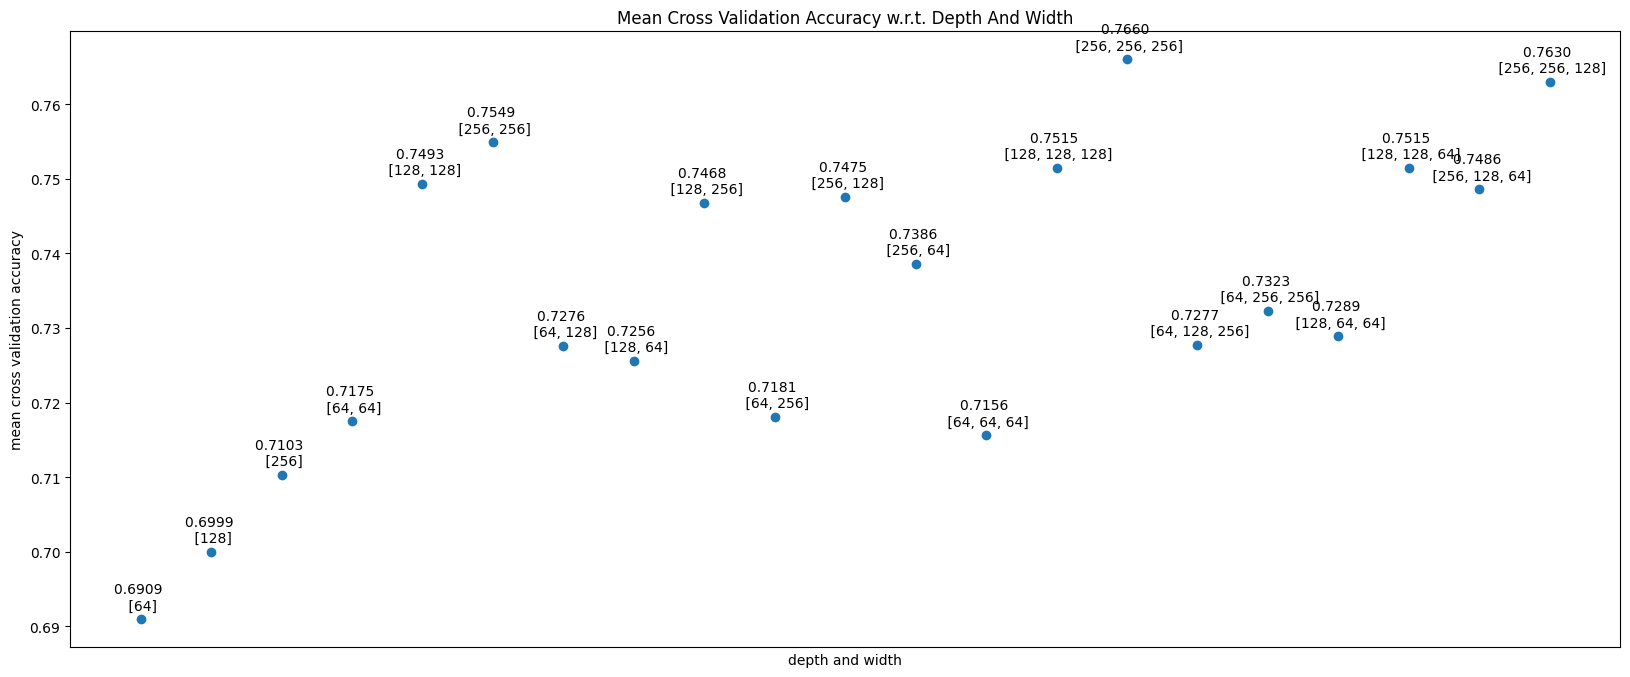

In [7]:
# YOUR CODE HERE
paras = list(cross_validation_accuracies.keys())
xt = range(1, len(paras) + 1)
plt.figure(figsize=(20, 8))
plt.xlabel('depth and width')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('mean cross validation accuracy')
plt.title('Mean Cross Validation Accuracy w.r.t. Depth And Width')
plt.scatter(xt, mean_accuracies)

for i, txt in enumerate(zip(xt, mean_accuracies)):
    plt.annotate(f'{txt[1]:.4f} \n {paras[i]}', (xt[i], mean_accuracies[i]), textcoords="offset points", xytext=(0, 7), ha='center')

5. Select the optimal combination for the depth and width. State the rationale for your selection.

In [8]:
optimal_combination = [256, 256, 256]
reason = "According to the result, 3 layers with 256 each performs the best because it has the highest mean cross validation accuracy. This is because the model is sophisticated enough to capture all the complicated information in the architecture."
# YOUR CODE HERE

6.Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.


Epoch 1, train_loss 0.679399 train_acc 0.561638, test_loss 0.666717, test_acc 0.593284
Epoch 2, train_loss 0.654207 train_acc 0.603940, test_loss 0.645762, test_acc 0.634328
Epoch 3, train_loss 0.632695 train_acc 0.638777, test_loss 0.647490, test_acc 0.632255
Epoch 4, train_loss 0.610213 train_acc 0.663453, test_loss 0.645858, test_acc 0.641791
Epoch 5, train_loss 0.583156 train_acc 0.686884, test_loss 0.598476, test_acc 0.686153
Epoch 6, train_loss 0.549633 train_acc 0.716122, test_loss 0.585182, test_acc 0.692371
Epoch 7, train_loss 0.525825 train_acc 0.732089, test_loss 0.562529, test_acc 0.699420
Epoch 8, train_loss 0.491427 train_acc 0.760290, test_loss 0.549669, test_acc 0.728027
Epoch 9, train_loss 0.474750 train_acc 0.765474, test_loss 0.539849, test_acc 0.739221
Epoch 10, train_loss 0.442257 train_acc 0.787351, test_loss 0.529168, test_acc 0.745854
Epoch 11, train_loss 0.417586 train_acc 0.804251, test_loss 0.534630, test_acc 0.756633
Epoch 12, train_loss 0.405150 train_acc 0

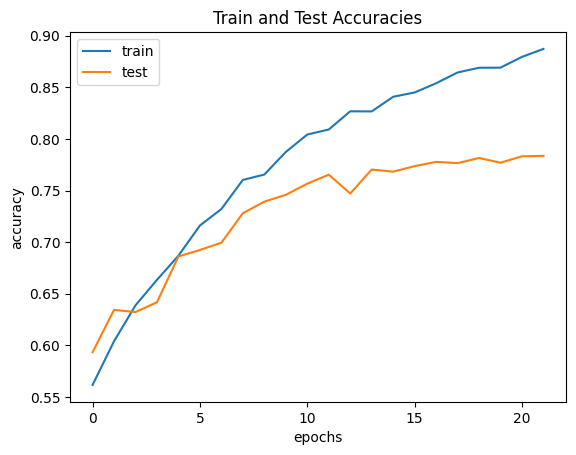

In [13]:
# YOUR CODE HERE
# YOUR CODE HERE
optimal_combination = [256, 256, 256]
no_features = 77 # feature number
no_labels = 1  # output label number
lr = 0.001  # learning rate

# initialize model
model = MLP()
para_list = []
optimal_combination.insert(0, no_features)
optimal_combination.append(no_labels)
for i in range(len(optimal_combination) - 1):
    para_list.append((optimal_combination[i], optimal_combination[i + 1]))
for j in range(len(para_list)):
    if j == len(para_list) - 1:
        model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
        model.add_layer(f"Sigmoid{j}", nn.Sigmoid())
    else:
        model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
        model.add_layer(f"ReLU{j}", nn.ReLU())
        model.add_layer(f"Dropout{j}", nn.Dropout(0.2))

# set Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr)

scaler = preprocessing.StandardScaler()
            
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_data = CustomDataset(X_train_scaled, y_train)
test_data = CustomDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False)

train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
no_epochs = 100

early_stopper = EarlyStopper(patience=3, min_delta=0)

# start training
for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)

    train_loss_.append(train_loss), train_acc_.append(train_acc)
    test_loss_.append(test_loss), test_acc_.append(test_acc)

    print(f"Epoch {epoch+1}, train_loss {train_loss:>7f} train_acc {train_acc:>4f}, test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")
    
    # early stop setting
    if early_stopper.early_stop(test_loss): 
        print("Early stopping!")
        break
print("Done!")

# save the model
torch.save(model.state_dict(), 'model.pth')

no_epochs = len(train_acc_)

# plot accuracies
plt.figure(1)
plt.plot(range(no_epochs), train_acc_, label='train')
plt.plot(range(no_epochs), test_acc_, label ='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Train and Test Accuracies")
plt.legend()

7.As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?

Intuition: sometimes the model goes to certain zone that we know it does not effective. However, we cannot ask it to go out because we just try all. How about having a search method that adaptively adjust the parameters based on the previous results.

Grid Search with Adaptive Sampling is a method that dynamically adjusts the grid of hyperparameter configurations based on the performance of previously evaluated configurations. This approach allows the search to focus on more promising regions of the hyperparameter space, thereby improving efficiency.

Follow the following steps:
1. Assume only one layer, so there is [[64], [128], [256]]
2. Choose the best one, says best1, run these combinations: [[best1, 64], [best1, 128], [best1, 256]]
3. Choose the best in (1), says best 2, run these combinations [[best1, best2, 64], [best1, best2, 128], [best1, best2, 256]].

By this way, we only need 9 iterations, while the original one needs 27.

In [15]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    no_features = 77 
    no_labels = 1

    cross_validation_accuracies, cross_validation_times = {}, {}

    # Step 1: Evaluate the initial set of parameters
    initial_parameters = [[64], [128], [256]]
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds(initial_parameters, X_train, y_train)
    for p in initial_parameters:
        para_str = str(p)
        accuracy = []
        last_epoch_time = []
        print(f"depth and width: {para_str}")
        
        para_list = [] 
        p.insert(0, no_features)
        p.append(no_labels)
        for i in range(len(p) - 1):
            para_list.append((p[i], p[i + 1]))
        
        for i in range(5):
            model = MLP()
            for j in range(len(para_list)):
                if j == len(para_list) - 1:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"Sigmoid{j}", nn.Sigmoid())
                else:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"ReLU{j}", nn.ReLU())
                    model.add_layer(f"Dropout{j}", nn.Dropout(0.2))

            X_train_scaled, y_train2 = X_train_scaled_dict[para_str][i], y_train_dict[para_str][i]
            X_val_scaled, y_val2 = X_val_scaled_dict[para_str][i], y_val_dict[para_str][i]

            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)

            print(f"experiment {i + 1}: accuracy: {test_accuracies[-1]:>4f}; last epoch time {times[-1]:>4f}")
            accuracy.append(test_accuracies[-1])
            last_epoch_time.append(times[-1])
        
        cross_validation_accuracies[para_str] = accuracy
        cross_validation_times[para_str] = last_epoch_time
        print(f"depth and width {para_str}: mean accuracy: {sum(cross_validation_accuracies[para_str]) / 5:>4f}; mean last epoch time {sum(cross_validation_times[para_str]) / 5:>4f}")
        print("----")

    # Step 2: Choose the best one from the initial set
    best1 = max(cross_validation_accuracies, key=lambda k: sum(cross_validation_accuracies[k]) / 5)
    best1 = eval(best1)[0]

    # Step 3: Evaluate combinations with the best one
    second_parameters = [[best1, 64], [best1, 128], [best1, 256]]
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds(second_parameters, X_train, y_train)
    for p in second_parameters:
        para_str = str(p)
        accuracy = []
        last_epoch_time = []
        print(f"depth and width: {para_str}")
        
        para_list = [] 
        p.insert(0, no_features)
        p.append(no_labels)
        for i in range(len(p) - 1):
            para_list.append((p[i], p[i + 1]))
        
        for i in range(5):
            model = MLP()
            for j in range(len(para_list)):
                if j == len(para_list) - 1:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"Sigmoid{j}", nn.Sigmoid())
                else:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"ReLU{j}", nn.ReLU())
                    model.add_layer(f"Dropout{j}", nn.Dropout(0.2))

            X_train_scaled, y_train2 = X_train_scaled_dict[para_str][i], y_train_dict[para_str][i]
            X_val_scaled, y_val2 = X_val_scaled_dict[para_str][i], y_val_dict[para_str][i]

            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)

            print(f"experiment {i + 1}: accuracy: {test_accuracies[-1]:>4f}; last epoch time {times[-1]:>4f}")
            accuracy.append(test_accuracies[-1])
            last_epoch_time.append(times[-1])
        
        cross_validation_accuracies[para_str] = accuracy
        cross_validation_times[para_str] = last_epoch_time
        print(f"depth and width {para_str}: mean accuracy: {sum(cross_validation_accuracies[para_str]) / 5:>4f}; mean last epoch time {sum(cross_validation_times[para_str]) / 5:>4f}")
        print("----")

    # Step 4: Choose the best one from the second set
    best2 = max(cross_validation_accuracies, key=lambda k: sum(cross_validation_accuracies[k]) / 5)
    best2 = eval(best2)[1]

    # Step 5: Evaluate combinations with the best ones from both sets
    final_parameters = [[best1, best2, 64], [best1, best2, 128], [best1, best2, 256]]
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds(final_parameters, X_train, y_train)

    for p in final_parameters:
        para_str = str(p)
        accuracy = []
        last_epoch_time = []
        print(f"depth and width: {para_str}")
        
        para_list = [] 
        p.insert(0, no_features)
        p.append(no_labels)
        for i in range(len(p) - 1):
            para_list.append((p[i], p[i + 1]))
        
        for i in range(5):
            model = MLP()
            for j in range(len(para_list)):
                if j == len(para_list) - 1:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"Sigmoid{j}", nn.Sigmoid())
                else:
                    model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
                    model.add_layer(f"ReLU{j}", nn.ReLU())
                    model.add_layer(f"Dropout{j}", nn.Dropout(0.2))

            X_train_scaled, y_train2 = X_train_scaled_dict[para_str][i], y_train_dict[para_str][i]
            X_val_scaled, y_val2 = X_val_scaled_dict[para_str][i], y_val_dict[para_str][i]

            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)

            print(f"experiment {i + 1}: accuracy: {test_accuracies[-1]:>4f}; last epoch time {times[-1]:>4f}")
            accuracy.append(test_accuracies[-1])
            last_epoch_time.append(times[-1])
        
        cross_validation_accuracies[para_str] = accuracy
        cross_validation_times[para_str] = last_epoch_time
        print(f"depth and width {para_str}: mean accuracy: {sum(cross_validation_accuracies[para_str]) / 5:>4f}; mean last epoch time {sum(cross_validation_times[para_str]) / 5:>4f}")
        print("----")

    return cross_validation_accuracies, cross_validation_times


Iteration 1
depth and width: [77, 256, 128, 1]


Early stopping at epoch 44!
experiment 1: accuracy: 0.513219; last epoch time 0.112282


KeyboardInterrupt: 